**Práctica 10: Clasificación de datos con sklearn**

Clasificación refiere a la asignación automática de datos en grupos previamente conocidos según sus atributos.
Para el caso de estudio, el escenario de mayor interés es poder determinar a través de cuáles atributos es posible clasificar los alumnos a
* los que pasaron en primera oportunidad
* los que pasaron en segunda oportunidad
* los que presentaron y reprobaron ambas (es decir, los de tercera oportunidad)

Algoritmos de __clasificación supervisada__ son entrenados de manera iterativa alimentándoles datos previamente etiquetados uno por uno, realizando ajustes al modelo de clasificación y luego validados proporcionándoles *nuevos* datos sin etiqueta asociada (pero conociendo las etiquetas a aquellos datos también), calculando qué tan bien el modelo logró asignar las etiquetas a estos datos de validación. Vamos a usar 70% para entrenar y el 30% para validar.

Usamos primero unos pocos de los mismos datos que se emplearon como entrada a PCA en la octava práctica con las [clasificadores de scikit-learn](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) para probar clasificadores con datos bidimensionales que son fáciles de visualizar.

1    98
2    21
0     7
Name: etiquetas, dtype: int64


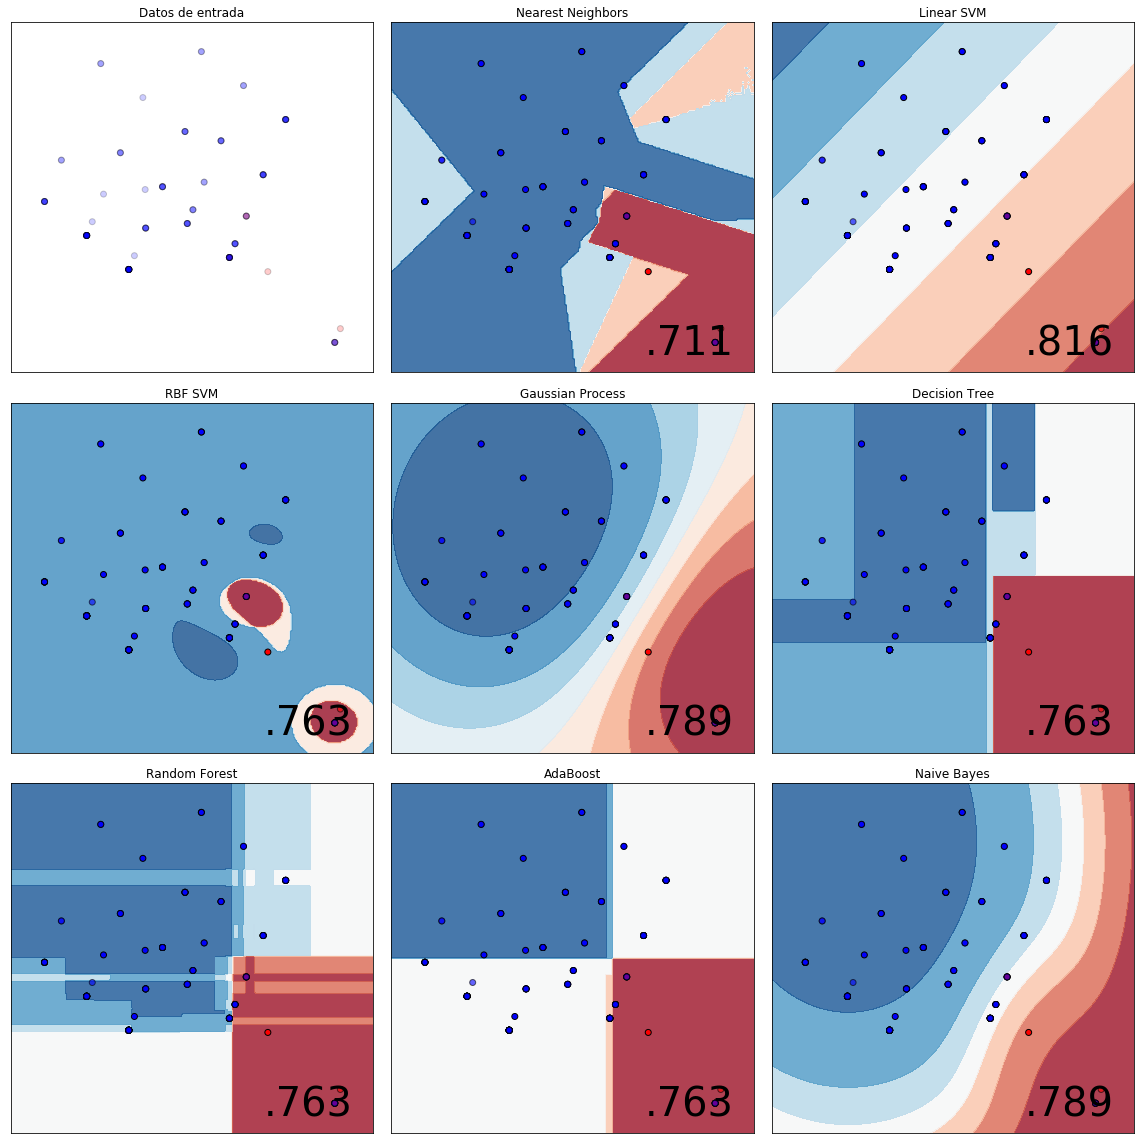

In [93]:
import ssl
import pandas as pd
from math import ceil, sqrt
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from numpy import isnan, nan, arange, meshgrid, c_
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
                                                                                                                  
if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context
o = pd.read_csv("https://elisa.dyndns-web.com/teaching/comp/datasci/modelar.csv")
e = o.loc[o.profe == 'elisa']
d = pd.concat([e.loc[e.CF1op >= 70], e.loc[~isnan(e.CF2op)]])
d = d.drop(['Unnamed: 0', 'Unnamed: 0.1', 'profe', 'ingreso', 'temas', 'sIng'], 1)
cat = pd.Categorical(d.inicio)
d.inicio = cat.codes
d.hrsNum = d.hrsNum.replace(nan, 0) # supongamos que los que no respondieron, no trabajan 
d.CF2op = d.CF2op.replace(nan, 0) # para no perder a los que pasaron en primera
d = d.dropna() # podemos únicamente usar los renglones que contienen todas las respuestas
pri = d.CF1op >= 70
seg = d.CF2op >= 70
ter = ~pri & ~seg
d['etiquetas'] = [1 if  pri[i] else (2 if seg[i] else (0 if ter[i] else "NA")) for i in pri.keys()] # etiquetas
print(d.etiquetas.value_counts())
y = d.etiquetas
xVars = ['inicio', 'hrsNum', 'eM']
x = d.loc[:, xVars].values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components = 2) # pedimos uno bidimensional
X = pca.fit_transform(x)
# código de https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html 
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process", \
         "Decision Tree", "Random Forest", "AdaBoost", "Naive Bayes"]
classifiers = [KNeighborsClassifier(3), SVC(kernel="linear", C=0.025), \
    SVC(gamma=2, C=1), GaussianProcessClassifier(1.0 * RBF(1.0)), \
    DecisionTreeClassifier(max_depth=5), RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), \
    AdaBoostClassifier(), GaussianNB()]
k = int(ceil(sqrt(len(classifiers) + 1)))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42) # división
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = meshgrid(arange(x_min, x_max, h), arange(y_min, y_max, 0.02))
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.rcParams["figure.figsize"] = [16, 16]
figure = plt.figure()
ax = plt.subplot(k, k, 1)
ax.set_title("Datos de entrada")
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, alpha=0.2, edgecolors='k') # entrenamiento
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.2, edgecolors='k') # validación
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i = 2
for name, clf in zip(names, classifiers):
    ax = plt.subplot(k, k, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        Z = clf.predict_proba(c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors='k', alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.3f' % score).lstrip('0'), size=40, horizontalalignment='right')
    i += 1
plt.tight_layout()
plt.show()

¿Cómo sabemos qué tan buenos eran los modelos para los tres casos? El puntaje de precisión (en la esquina inferior de las gráficas) aglomera todo en un sólo número... Para eso son las [matríces de confusión](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) que permiten ver cuántos datos fueron clasificados correctamente y cuáles eran los errores.

In [94]:
import ssl
import pandas as pd
from math import ceil, sqrt
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from numpy import isnan, nan
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
                                                                                                                  
if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context
o = pd.read_csv("https://elisa.dyndns-web.com/teaching/comp/datasci/modelar.csv")
e = o.loc[o.profe == 'elisa']
d = pd.concat([e.loc[e.CF1op >= 70], e.loc[~isnan(e.CF2op)]])
d = d.drop(['Unnamed: 0', 'Unnamed: 0.1', 'profe', 'ingreso', 'temas', 'sIng'], 1)
cat = pd.Categorical(d.inicio)
d.inicio = cat.codes
d.hrsNum = d.hrsNum.replace(nan, 0) # supongamos que los que no respondieron, no trabajan 
d.CF2op = d.CF2op.replace(nan, 0) # para no perder a los que pasaron en primera
d = d.dropna() # podemos únicamente usar los renglones que contienen todas las respuestas
pri = d.CF1op >= 70
seg = d.CF2op >= 70
ter = ~pri & ~seg
y = [1 if  pri[i] else (2 if seg[i] else (0 if ter[i] else "NA")) for i in pri.keys()] # etiquetas
xVars = ['inicio', 'hrsNum', 'eM']
x = d.loc[:, xVars].values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components = 2) # pedimos uno bidimensional
X = pca.fit_transform(x)
# código de https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html 
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process", \
         "Decision Tree", "Random Forest", "AdaBoost", "Naive Bayes"]
classifiers = [KNeighborsClassifier(3), SVC(kernel="linear", C=0.025), \
    SVC(gamma=2, C=1), GaussianProcessClassifier(1.0 * RBF(1.0)), \
    DecisionTreeClassifier(max_depth=5), RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), \
    AdaBoostClassifier(), GaussianNB()]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42) # la misma división
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    print(name, clf.score(X_test, y_test))
    expected, predicted = y_test, clf.predict(X_test)
    print(metrics.classification_report(expected, predicted))
    print(metrics.confusion_matrix(expected, predicted))
    print('-' * 60)

Nearest Neighbors 0.710526315789
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.84      0.84      0.84        31
           2       0.17      0.17      0.17         6

   micro avg       0.71      0.71      0.71        38
   macro avg       0.34      0.34      0.34        38
weighted avg       0.71      0.71      0.71        38

[[ 0  0  1]
 [ 1 26  4]
 [ 0  5  1]]
------------------------------------------------------------
Linear SVM 0.815789473684
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.82      1.00      0.90        31
           2       0.00      0.00      0.00         6

   micro avg       0.82      0.82      0.82        38
   macro avg       0.27      0.33      0.30        38
weighted avg       0.67      0.82      0.73        38

[[ 0  1  0]
 [ 0 31  0]
 [ 0  6  0]]
--------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Gaussian Process 0.789473684211
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.83      0.97      0.90        31
           2       0.00      0.00      0.00         6

   micro avg       0.79      0.79      0.79        38
   macro avg       0.28      0.32      0.30        38
weighted avg       0.68      0.79      0.73        38

[[ 0  0  1]
 [ 0 30  1]
 [ 0  6  0]]
------------------------------------------------------------
Decision Tree 0.763157894737
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.85      0.90      0.88        31
           2       0.25      0.17      0.20         6

   micro avg       0.76      0.76      0.76        38
   macro avg       0.37      0.36      0.36        38
weighted avg       0.73      0.76      0.75        38

[[ 0  0  1]
 [ 1 28  2]
 [ 0  5  1]]
------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Son tan pocos alumnos con datos completos que estuvieron en terceras que nos está causando advertencias su presencia ya que nada termina siendo clasificado en ese grupo. Rehagamos los modelos pero con solamente dos etiquetas: sí o no pasó en primera oportunidad. Aumentemos el conjunto de prueba a 40% para mejorar la posibilidad de que contenga alumnos que no pasaron en primera oportunidad.

1    98
0    28
Name: etiquetas, dtype: int64


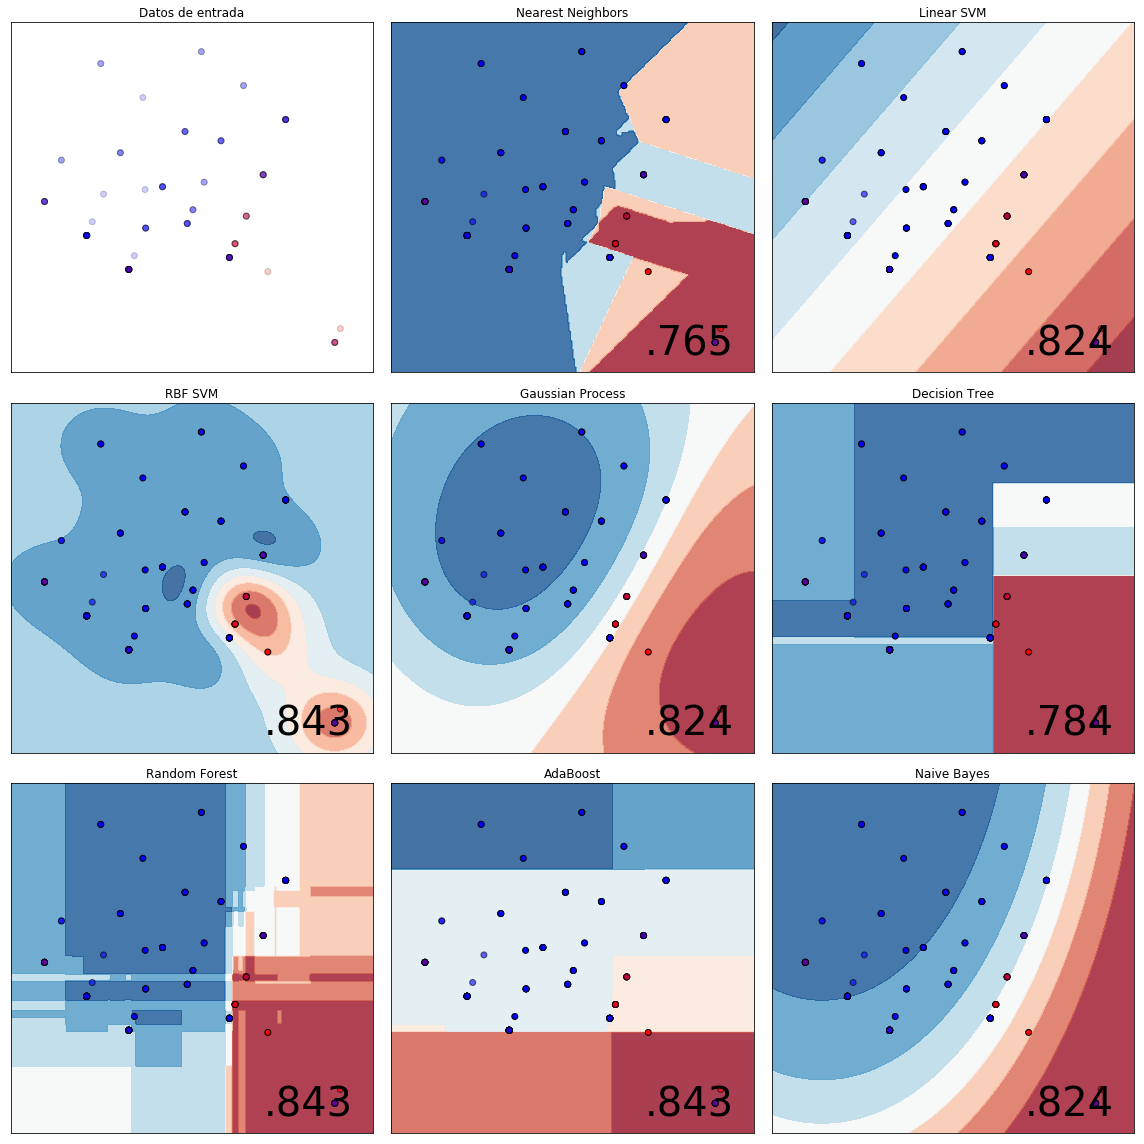

In [95]:
import ssl
import pandas as pd
from math import ceil, sqrt
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from numpy import isnan, nan, arange, meshgrid, c_
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
                                                                                                                  
if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context
o = pd.read_csv("https://elisa.dyndns-web.com/teaching/comp/datasci/modelar.csv")
e = o.loc[o.profe == 'elisa']
d = pd.concat([e.loc[e.CF1op >= 70], e.loc[~isnan(e.CF2op)]])
d = d.drop(['Unnamed: 0', 'Unnamed: 0.1', 'profe', 'ingreso', 'temas', 'sIng'], 1)
cat = pd.Categorical(d.inicio)
d.inicio = cat.codes
d.hrsNum = d.hrsNum.replace(nan, 0) # supongamos que los que no respondieron, no trabajan 
d.CF2op = d.CF2op.replace(nan, 0) # para no perder a los que pasaron en primera
d = d.dropna() # podemos únicamente usar los renglones que contienen todas las respuestas
pri = d.CF1op >= 70
d['etiquetas'] = [1 if  pri[i] else 0 for i in pri.keys()] # etiquetas
print(d.etiquetas.value_counts())
y = d.etiquetas
xVars = ['inicio', 'hrsNum', 'eM']
x = d.loc[:, xVars].values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components = 2) # pedimos uno bidimensional
X = pca.fit_transform(x)
# código de https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html 
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process", \
         "Decision Tree", "Random Forest", "AdaBoost", "Naive Bayes"]
classifiers = [KNeighborsClassifier(3), SVC(kernel="linear", C=0.025), \
    SVC(gamma=2, C=1), GaussianProcessClassifier(1.0 * RBF(1.0)), \
    DecisionTreeClassifier(max_depth=5), RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), \
    AdaBoostClassifier(), GaussianNB()]
k = int(ceil(sqrt(len(classifiers) + 1)))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42) # división
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = meshgrid(arange(x_min, x_max, h), arange(y_min, y_max, 0.02))
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.rcParams["figure.figsize"] = [16, 16]
figure = plt.figure()
ax = plt.subplot(k, k, 1)
ax.set_title("Datos de entrada")
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, alpha=0.2, edgecolors='k') # entrenamiento
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.2, edgecolors='k') # validación
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i = 2
for name, clf in zip(names, classifiers):
    ax = plt.subplot(k, k, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors='k', alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.3f' % score).lstrip('0'), size=40, horizontalalignment='right')
    i += 1
plt.tight_layout()
plt.show()

In [76]:
import ssl
import pandas as pd
from math import ceil, sqrt
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from numpy import isnan, nan
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
                                                                                                                  
if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context
o = pd.read_csv("https://elisa.dyndns-web.com/teaching/comp/datasci/modelar.csv")
e = o.loc[o.profe == 'elisa']
d = pd.concat([e.loc[e.CF1op >= 70], e.loc[~isnan(e.CF2op)]])
d = d.drop(['Unnamed: 0', 'Unnamed: 0.1', 'profe', 'ingreso', 'temas', 'sIng'], 1)
cat = pd.Categorical(d.inicio)
d.inicio = cat.codes
d.hrsNum = d.hrsNum.replace(nan, 0) # supongamos que los que no respondieron, no trabajan 
d.CF2op = d.CF2op.replace(nan, 0) # para no perder a los que pasaron en primera
d = d.dropna() # podemos únicamente usar los renglones que contienen todas las respuestas
pri = d.CF1op >= 70
d['etiquetas'] = [1 if  pri[i] else 0 for i in pri.keys()] # etiquetas
print(d.etiquetas.value_counts())
y = d.etiquetas
xVars = ['inicio', 'hrsNum', 'eM']
x = d.loc[:, xVars].values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components = 2) # pedimos uno bidimensional
X = pca.fit_transform(x)
# código de https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html 
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process", \
         "Decision Tree", "Random Forest", "AdaBoost", "Naive Bayes"]
classifiers = [KNeighborsClassifier(3), SVC(kernel="linear", C=0.025), \
    SVC(gamma=2, C=1), GaussianProcessClassifier(1.0 * RBF(1.0)), \
    DecisionTreeClassifier(max_depth=5), RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), \
    AdaBoostClassifier(), GaussianNB()]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42) # la misma división
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    print(name, clf.score(X_test, y_test))
    expected, predicted = y_test, clf.predict(X_test)
    print(metrics.classification_report(expected, predicted))
    print(metrics.confusion_matrix(expected, predicted))
    print('-' * 60)

1    98
0    28
Name: etiquetas, dtype: int64
Nearest Neighbors 0.764705882353
              precision    recall  f1-score   support

           0       0.36      0.44      0.40         9
           1       0.88      0.83      0.85        42

   micro avg       0.76      0.76      0.76        51
   macro avg       0.62      0.64      0.63        51
weighted avg       0.78      0.76      0.77        51

[[ 4  5]
 [ 7 35]]
------------------------------------------------------------
Linear SVM 0.823529411765
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.82      1.00      0.90        42

   micro avg       0.82      0.82      0.82        51
   macro avg       0.41      0.50      0.45        51
weighted avg       0.68      0.82      0.74        51

[[ 0  9]
 [ 0 42]]
------------------------------------------------------------
RBF SVM 0.843137254902
              precision    recall  f1-score   support

   

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Una buena matriz de confusión tiene valores grandes en el diagonal y valores bajos en otros lados. Ninguno de estos modelos salió muy bueno, pero el que menos pena da es el proceso gaussiano que sacó un 0.823529411765
con 5 correctos y 4 incorrectos entre los que _no_ aprobaron primera oportunidad y 37 correctos versus 5 incorrectos entre los que sí aprobaron. Es obvio que desempeña mejor con los que sí aprobaron. Todos los demás modelos batallaron aún más con la clasificación de los que aprobaron. Un ajuste de parámetros puede ayudar a mejorar, igual como introducción de nuevos atributos, aumento de dimensiones (ya no se puede dibujar lindo y bonito, pero igual se puede calcular), agregar más datos, y otros trucos. Hagamos un intento de ese tipo:

In [104]:
import ssl
import pandas as pd
from math import ceil, sqrt
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from numpy import isnan, nan
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
                                                                                                                  
if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context
o = pd.read_csv("https://elisa.dyndns-web.com/teaching/comp/datasci/modelar.csv")
d = o.loc[o.profe == 'elisa']
xv = ['CF1op', 'grupo', 'sem', 'PE', 'inicio', 'hrsNum', 'eI', 'fueAses', 'cuantasTemas', \
        'formasApoyo', 'cuantosMedios', 'hrsEstudio_ini', 'hrsEstudio_mcu', \
        'sabePromedio', 'sabeCreditos', 'sabeHoras', 'sabeAmbos', \
        'noSabeCreditos', 'noSabeHoras', 'noSabeNinguno']
d = d.loc[:, xv]
for c in ['grupo', 'sem', 'PE', 'inicio', 'fueAses', \
         'sabePromedio', 'sabeCreditos', 'sabeHoras', 'sabeAmbos', \
         'noSabeCreditos', 'noSabeHoras', 'noSabeNinguno']:
    cat = pd.Categorical(d[c])
    d[c] = cat.codes
viejos = ['3-5 h', '2-3 h', '> 5 h', '1-2 h', '< 1 h', 'Nada', nan]
nuevos = [4, 2.5, 7, 1.5, 0.5, 0, 0]
for c in ['hrsEstudio_ini', 'hrsEstudio_mcu']:      
    d[c] = d[c].replace(viejos, nuevos) 
d.hrsNum = d.hrsNum.replace(nan, 0) 
d = d.dropna() 
d['etiqueta'] = d.CF1op >= 70
y = d.etiqueta
print(y.value_counts())
d = d.drop(['etiqueta'], 1)  
X = StandardScaler().fit_transform(d.values) # ahora SIN ejecutar PCA antes
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process", \
         "Decision Tree", "Random Forest", "AdaBoost", "Naive Bayes"]
classifiers = [KNeighborsClassifier(3), SVC(kernel="linear", C=0.025), \
    SVC(gamma=2, C=1), GaussianProcessClassifier(1.0 * RBF(1.0)), \
    DecisionTreeClassifier(max_depth=5), RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), \
    AdaBoostClassifier(), GaussianNB()]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5) # cada ejecución tiene una división al azar
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    y_m = clf.predict(X_test)
    print(name, metrics.classification_report(y_test, y_m))
    print(metrics.confusion_matrix(y_test, y_m))
    print('-' * 60)

False    207
True     198
Name: etiqueta, dtype: int64
Nearest Neighbors               precision    recall  f1-score   support

       False       0.74      0.83      0.78       103
        True       0.80      0.70      0.74       100

   micro avg       0.76      0.76      0.76       203
   macro avg       0.77      0.76      0.76       203
weighted avg       0.77      0.76      0.76       203

[[85 18]
 [30 70]]
------------------------------------------------------------
Linear SVM               precision    recall  f1-score   support

       False       0.92      0.81      0.86       103
        True       0.82      0.93      0.87       100

   micro avg       0.87      0.87      0.87       203
   macro avg       0.87      0.87      0.87       203
weighted avg       0.87      0.87      0.87       203

[[83 20]
 [ 7 93]]
------------------------------------------------------------
RBF SVM               precision    recall  f1-score   support

       False       0.52      1.00      

Ahora que no se especifica semilla a la división entre conjuntos de entrenamiento y prueba, cada ejecución reporta resultados distintos. Algunos clasificadores ya logran perfección; he visto clasificaciones de AdaBoost y DecisionTree con puntajes de 1.00 en ambas clases.

En el décimo reporte, utiliza por lo menos tres distintos métodos de clasificación a por lo menos una división de interés en tus datos, primero con una proyección o selección bidimensional de atributos para visualizar el resultado y luego con por lo menos una dimensión mayor. Evalúa la calidad de la clasificación resultante e intenta mejorarlo con un ajuste de parámetros si es que los mejores métodos los tengan (en el ejemplo arriba, AdaBoost no toma ningún parámetro obligatorio).